In [1]:
import torch
import sklearn
import numpy as np
import pandas as pd
from torch import nn
import sklearn.datasets
import sklearn.linear_model
import torch.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sklearn.model_selection
plt.rcParams['figure.dpi'] = 200
from joblib import Parallel, delayed
import h5py

In [116]:
class ConcreteNN(nn.Module):

  def __init__(self, size):
    super().__init__()
    # layers
    self.input_layer = nn.Linear(size, size)     
    self.hidden_layer = nn.Linear(size, size)
    self.output_layer = nn.Linear(size, 1) 
    self.activation = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.activation(x)
    x = self.hidden_layer(x)
    x = self.activation(x)
    x = self.output_layer(x)
    return x

def test_loss(model, X_test, y_test):
  model.eval()
  output = model(X_test).flatten()
  loss = sklearn.metrics.mean_squared_error(y_test.detach().numpy(), output.detach().numpy())
  return loss.item()

def test_lossR2(model, X_test, y_test):
  model.eval()
  output = model(X_test).flatten()
  loss = sklearn.metrics.r2_score(y_test.detach().numpy(), output.detach().numpy())
  return loss.item()

In [40]:
# Import small dataset (n=103)
data = pd.read_csv("slump_test.csv")

X = torch.FloatTensor(data.iloc[:, 1:10].values)
y = torch.FloatTensor(data.iloc[:, 10].values)
x_min = X.min(dim=0)[0]
x_max = X.max(dim=0)[0]
X = (X - x_min) / (x_max - x_min) # min max scaler

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.76, random_state=1)

<KeysViewHDF5 ['Lambdas', 'Losses', 'Sigmas']>


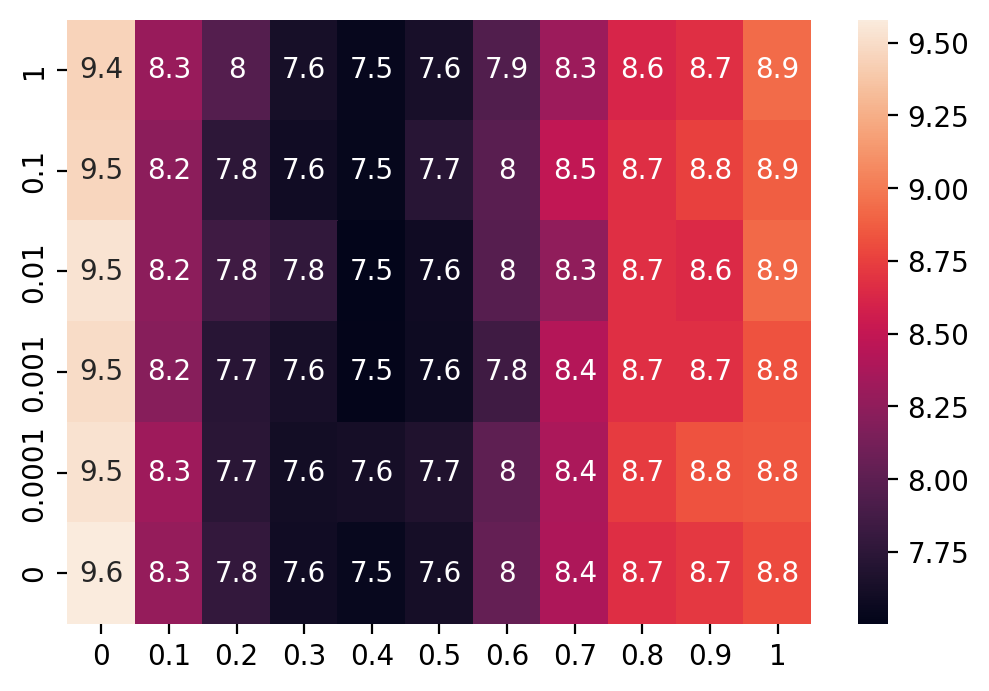

In [15]:
lambs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sigmas = [1, 0.1, 0.01, 0.001, 0.0001, 0]
lambs_, sigmas_ = np.meshgrid(lambs, sigmas)
hf = h5py.File('warmstarting_lr_study.h5', 'r')
print(hf.keys())
losses = np.array(hf.get('Losses')).reshape(lambs_.shape)
lambs_str = [str(x) for x in lambs]
sigmas_str = [str(x) for x in sigmas]
import seaborn as sns
ax = sns.heatmap(losses, annot=True, xticklabels=lambs_str, yticklabels=sigmas_str)

# Analyse Results

In [186]:
def get_groupdata(groupkey):
    vanilla_data = []
    for key in groupkey.keys():
        vanilla_data.append(groupkey.get(key))
        
    testr2 = np.array(vanilla_data[0])
    testrmse = np.array(vanilla_data[1])
    trainr2 = np.array(vanilla_data[2])
    trainrmse = np.array(vanilla_data[3])
    return testr2, testrmse, trainr2, trainrmse
def print_things(testr2, testrmse, trainr2, trainrmse):
    print('Test R2: ', testr2.mean())
    print('Test RMSE: ', testrmse.mean())
    print('Train R2 ', trainr2.mean())
    print('Train RMSE', trainrmse.mean())

In [188]:
hf = h5py.File('warmstarting_studiesv6.h5', 'r')
groups = []
for key in hf.keys():
    groups.append(hf.get(key))

# Vanilla
testr2va, testrmseva, trainr2va, trainrmseva = get_groupdata(groups[1])
print('Vanilla')
print_things(testr2va, testrmseva, trainr2va, trainrmseva)
print()
# warmstarting
testr2w, testrmsew, trainr2w, trainrmsew = get_groupdata(groups[2])
print('Warmstarting')
print_things(testr2w, testrmsew, trainr2w, trainrmsew)
print()
# shrinking perturbing
testrsp, testrmsesp, trainr2sp, trainrmsesp = get_groupdata(groups[0])
print('Shrinking and Perturbing')
print_things(testrsp, testrmsesp, trainr2sp, trainrmsesp)

Vanilla
Test R2:  0.7248647341430908
Test RMSE:  10.50503534269333
Train R2  0.8696988680728638
Train RMSE 7.8357456703186035

Warmstarting
Test R2:  0.7457464630390965
Test RMSE:  9.648899240493774
Train R2  0.8887430221691214
Train RMSE 6.704517044067383

Shrinking and Perturbing
Test R2:  0.8029758217641074
Test RMSE:  8.050630965232848
Train R2  0.9076916474120181
Train RMSE 5.565360397815704


# Initialize LR weights

In [103]:
LR = sklearn.linear_model.LinearRegression(fit_intercept=True)
inputs_reg = X_train[:, [0, 3, 5, 6]]
LR.fit(inputs_reg, y_train)
init_weights = LR.coef_
print(init_weights)

[  9.867108 -22.406433 -21.162289 -15.354101]


# Vanilla Network

Text(0.5, 1.0, 'Test Loss Last Epoch: 11.935839653015137')

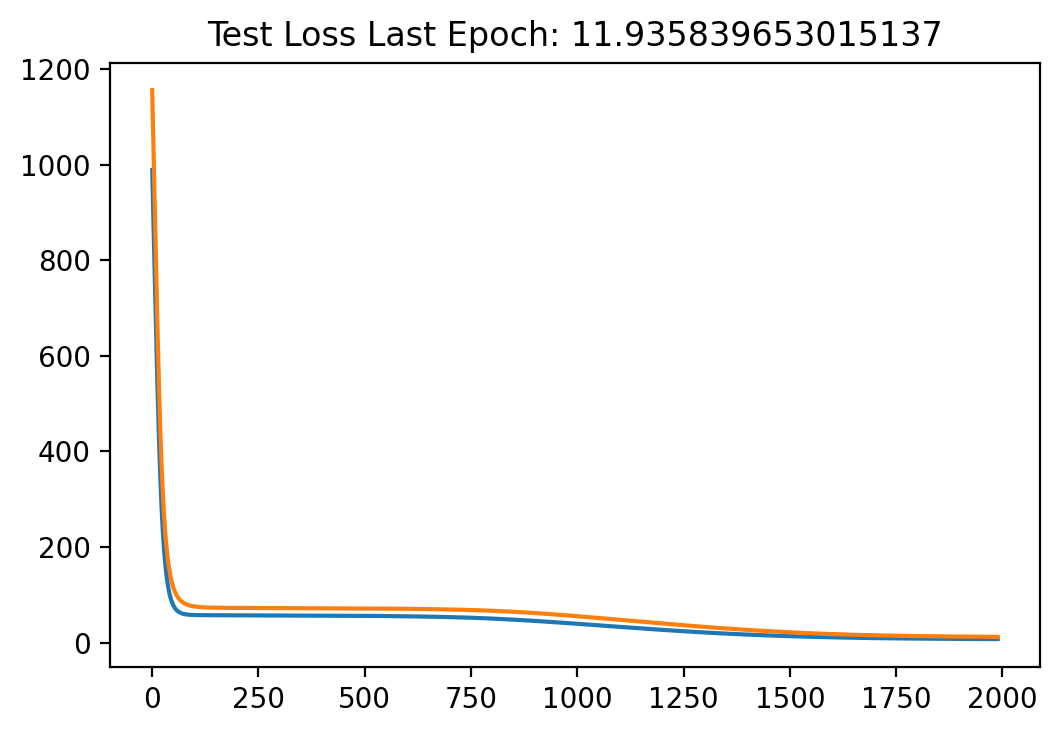

In [117]:
modelVa = ConcreteNN(9)
# train
criterion = nn.MSELoss()
optimizer= torch.optim.SGD(modelVa.parameters(), lr=0.001, momentum= 0.5)
epochs = 2000
loss_over_time = []
test_loss_over_time = []
for i in range(epochs):
    modelVa.train()
    optimizer.zero_grad()
    output = modelVa(X_train).flatten()
    loss = criterion(y_train, output)
    loss_over_time.append(loss.item())
    test_loss_over_time.append(test_loss(model=modelVa, X_test=X_test, y_test=y_test))
    loss.backward()
    optimizer.step()

n =10
plt.figure()
plt.plot(loss_over_time[n:])
plt.plot(test_loss_over_time[n:])
plt.title('Test Loss Last Epoch: {}'.format(test_loss_over_time[-1]))

Text(0, 0.5, 'compressive strength')

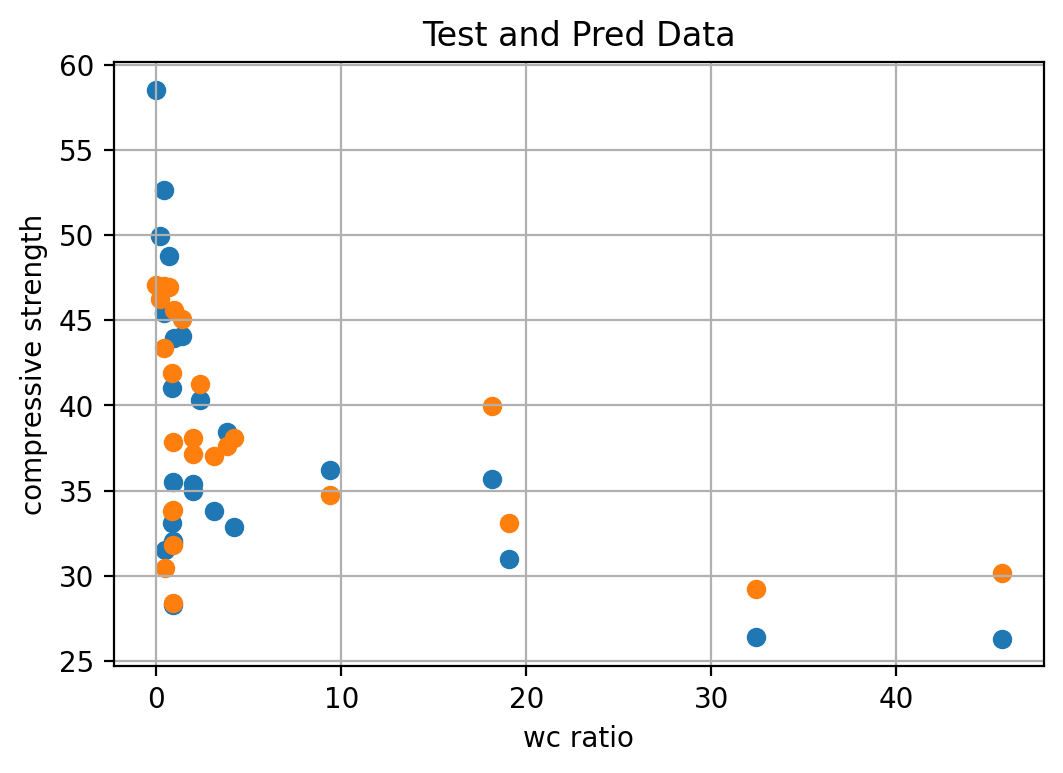

In [118]:
y_pred = modelVa(X_test).detach().numpy()
x_axis = X_test[:, 3]/X_test[:, 0]
plt.figure()
plt.scatter(x_axis, y_test)
plt.scatter(x_axis, y_pred)
plt.grid()
plt.title('Test and Pred Data')
plt.xlabel('wc ratio')
plt.ylabel('compressive strength')

In [142]:
def train_cv(train_index, test_index, mode):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = ConcreteNN(9)

    if mode == 'warmstarting':
        init_input = [0, 3, 5, 6]
        LR = sklearn.linear_model.LinearRegression(fit_intercept=True)
        inputs_reg = X_train[:, [0, 3, 5, 6]]
        LR.fit(inputs_reg, y_train)
        init_weights = LR.coef_
        with torch.no_grad():
            for i, (init) in enumerate(init_input):
                model.input_layer.weight[init][init] = torch.Tensor([init_weights[i]])

    elif mode == 'warmstartingSP':
        init_input = [0, 3, 5, 6]
        lamda = 0.4
        sigma = 0.001
        LR = sklearn.linear_model.LinearRegression(fit_intercept=True)
        inputs_reg = X_train[:, [0, 3, 5, 6]]
        LR.fit(inputs_reg, y_train)
        init_weights = LR.coef_
        with torch.no_grad():
            for i, (init) in enumerate(init_input):
                model.input_layer.weight[init][init] = torch.Tensor([init_weights[i]]) * lamda + torch.normal(0.0, sigma, size=(1,1))
    else:
        None
    
    criterion = nn.MSELoss()
    optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
    epochs = 2000

    # Training Loop
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train).flatten()
        loss = criterion(y_train, output)
        loss.backward()
        optimizer.step()

    testRMSE = test_loss(model=model, X_test=X_test, y_test=y_test)
    testR2 = test_lossR2(model=model, X_test=X_test, y_test =y_test)
    trainRMSE = test_loss(model=model, X_test=X_train, y_test=y_train)
    trainR2 = test_lossR2(model=model, X_test=X_train, y_test=y_train)

    return testRMSE, testR2, trainRMSE, trainR2

def train_multirun(K, mode):
    skf = sklearn.model_selection.KFold(n_splits=K)
    testRMSEcv, testR2cv, trainRMSEcv, trainR2cv = Parallel(n_jobs=-1)(delayed(train_cv)(train_index, test_index, mode) for train_index, test_index in skf.split(X, y))

    return testRMSEcv, testR2cv, trainRMSEcv, trainR2cv

K = 10
multiruns = 50

testRMSEcv, testR2cv, trainRMSEcv, trainR2cv = Parallel(n_jobs=-1)(delayed(train_multirun)(K, 'warmstarting') for i in range(multiruns))

# Test LR weights Network

Text(0.5, 1.0, 'Test Loss Last Epoch: 13.018610000610352')

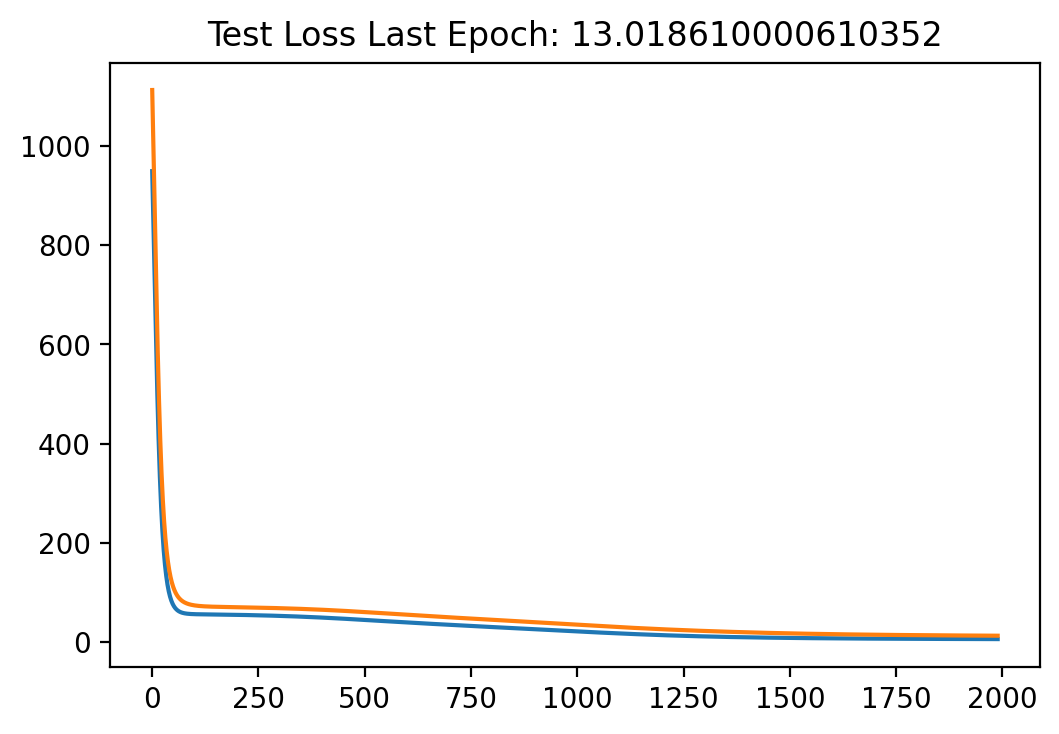

In [119]:
modelLR = ConcreteNN(9)
# change parameters in the input layer
init_input = [0, 3, 5, 6]
with torch.no_grad():
    for i, (init) in enumerate(init_input):
        modelLR.input_layer.weight[init][init] = torch.Tensor([init_weights[i]])

# train
criterion = nn.MSELoss()
optimizer= torch.optim.SGD(modelLR.parameters(), lr=0.001, momentum= 0.5)
epochs = 2000
loss_over_time = []
test_loss_over_time = []
gradients = []
for i in range(epochs):
    modelLR.train()
    optimizer.zero_grad()
    output = modelLR(X_train).flatten()
    loss = criterion(y_train, output)
    loss_over_time.append(loss.item())
    test_loss_over_time.append(test_loss(model=modelLR, X_test=X_test, y_test=y_test))
    loss.backward()
    optimizer.step()

n =10
plt.figure()
plt.plot(loss_over_time[n:])
plt.plot(test_loss_over_time[n:])
plt.title('Test Loss Last Epoch: {}'.format(test_loss_over_time[-1]))

Text(0, 0.5, 'compressive strength')

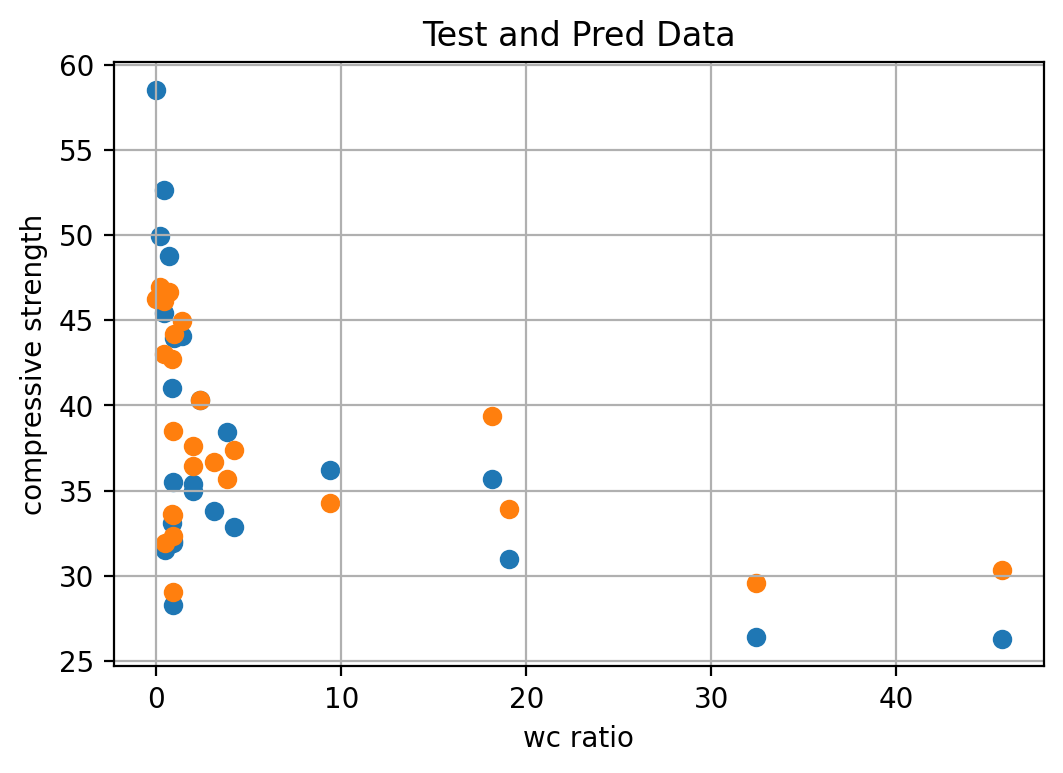

In [120]:
y_pred = modelLR(X_test).detach().numpy()
x_axis = X_test[:, 3]/X_test[:, 0]
plt.figure()
plt.scatter(x_axis, y_test)
plt.scatter(x_axis, y_pred)
plt.grid()
plt.title('Test and Pred Data')
plt.xlabel('wc ratio')
plt.ylabel('compressive strength')

# Test LR weights + Shrinkage and Perturbing Network

Text(0.5, 1.0, 'Test Loss Last Epoch: 10.462043762207031')

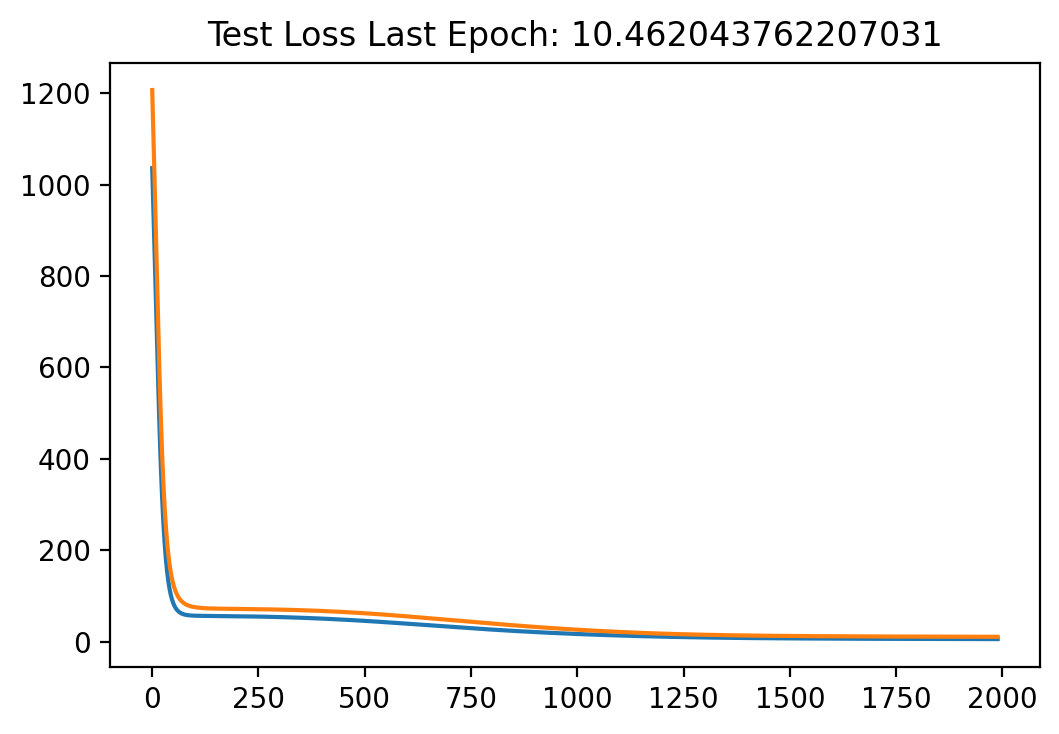

In [121]:
modelLRSP = ConcreteNN(9)
# change parameters in the input layer
init_input = [0, 3, 5, 6]
lamda = 0.4
sigma = 0.001
with torch.no_grad():
    for i, (init) in enumerate(init_input):
        modelLRSP.input_layer.weight[init][init] = torch.Tensor([init_weights[i]]) * lamda + torch.normal(0.0, sigma, size=(1,1))

# train
criterion = nn.MSELoss()
optimizer= torch.optim.SGD(modelLRSP.parameters(), lr=0.001, momentum= 0.5)
epochs = 2000
loss_over_time = []
test_loss_over_time = []
for i in range(epochs):
    modelLR.train()
    optimizer.zero_grad()
    output = modelLRSP(X_train).flatten()
    loss = criterion(y_train, output)
    loss_over_time.append(loss.item())
    test_loss_over_time.append(test_loss(model=modelLRSP, X_test=X_test, y_test=y_test))
    loss.backward()
    optimizer.step()

n =10
plt.figure()
plt.plot(loss_over_time[n:])
plt.plot(test_loss_over_time[n:])
plt.title('Test Loss Last Epoch: {}'.format(test_loss_over_time[-1]))

Text(0, 0.5, 'compressive strength')

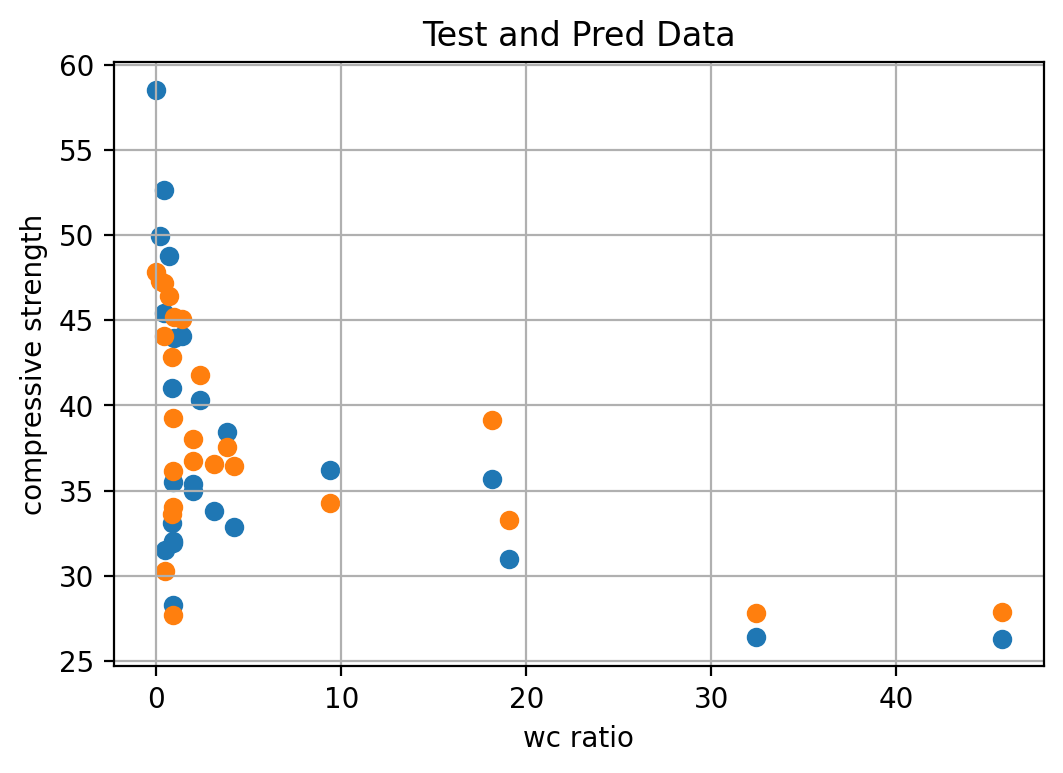

In [122]:
y_pred = modelLRSP(X_test).detach().numpy()
x_axis = X_test[:, 3]/X_test[:, 0]
plt.figure()
plt.scatter(x_axis, y_test)
plt.scatter(x_axis, y_pred)
plt.grid()
plt.title('Test and Pred Data')
plt.xlabel('wc ratio')
plt.ylabel('compressive strength')

In [ ]:
def train_cv(train_index, test_index):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = ConcreteNN(9)
    init_input = [0, 3, 5, 6]
    lamda = 0.4
    sigma = 0.001
    
    with torch.no_grad():
        for i, (init) in enumerate(init_input):
            modelLRSP.input_layer.weight[init][init] = torch.Tensor([init_weights[i]]) * lamda + torch.normal(0.0, sigma, size=(1,1))

    criterion = nn.MSELoss()
    optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
    epochs = 2000

    # Training Loop
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train).flatten()
        loss = criterion(y_train, output)
        loss.backward()
        optimizer.step()
    return test_loss(model=model, X_test=X_test, y_test=y_test)

def train_multirun(K, i):
    skf = sklearn.model_selection.KFold(n_splits=K)
    skf.get_n_splits(X, y)
    cv_loss_test = Parallel(n_jobs=-1)(delayed(train_cv)(train_index, test_index) for train_index, test_index in skf.split(X, y))
    return cv_loss_test

K = 10
multiruns = 50

cv_loss = Parallel(n_jobs=-1)(delayed(train_multirun)(K, i) for i in range(multiruns))
print('RMSE: ', np.mean(cv_loss))

10.30941989183426

In [82]:
def train_cv(train_index, test_index):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = ConcreteNN(9)
    init_input = [0, 3, 5, 6]
    lamda = 0.4
    sigma = 0.001
    
    with torch.no_grad():
        for i, (init) in enumerate(init_input):
            modelLRSP.input_layer.weight[init][init] = torch.Tensor([init_weights[i]]) * lamda + torch.normal(0.0, sigma, size=(1,1))

    criterion = nn.MSELoss()
    optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
    epochs = 2000

    # Training Loop
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train).flatten()
        loss = criterion(y_train, output)
        loss.backward()
        optimizer.step()
    return test_lossR2(model=model, X_test=X_test, y_test=y_test)

def train_multirun(K, i):
    skf = sklearn.model_selection.KFold(n_splits=K)
    skf.get_n_splits(X, y)
    cv_loss_test = Parallel(n_jobs=-1)(delayed(train_cv)(train_index, test_index) for train_index, test_index in skf.split(X, y))
    return cv_loss_test

K = 10
multiruns = 50

cv_r2= Parallel(n_jobs=-1)(delayed(train_multirun)(K, i) for i in range(multiruns))
print('R2: ', np.mean(cv_r2))

R2:  0.7224181461496232


In [138]:
def train_cv(train_index, test_index, mode):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = ConcreteNN(9)

    if mode == 'warmstarting':
        init_input = [0, 3, 5, 6]
        LR = sklearn.linear_model.LinearRegression(fit_intercept=True)
        inputs_reg = X_train[:, [0, 3, 5, 6]]
        LR.fit(inputs_reg, y_train)
        init_weights = LR.coef_
        with torch.no_grad():
            for i, (init) in enumerate(init_input):
                model.input_layer.weight[init][init] = torch.Tensor([init_weights[i]])

    elif mode == 'warmstartingSP':
        init_input = [0, 3, 5, 6]
        lamda = 0.4
        sigma = 0.001
        LR = sklearn.linear_model.LinearRegression(fit_intercept=True)
        inputs_reg = X_train[:, [0, 3, 5, 6]]
        LR.fit(inputs_reg, y_train)
        init_weights = LR.coef_
        with torch.no_grad():
            for i, (init) in enumerate(init_input):
                model.input_layer.weight[init][init] = torch.Tensor([init_weights[i]]) * lamda + torch.normal(0.0, sigma, size=(1,1))
    else:
        None
    
    criterion = nn.MSELoss()
    optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
    epochs = 2000

    # Training Loop
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train).flatten()
        loss = criterion(y_train, output)
        loss.backward()
        optimizer.step()

    testRMSE = test_loss(model=model, X_test=X_test, y_test=y_test)
    testR2 = test_lossR2(model=model, X_test=X_test, y_test =y_test)
    trainRMSE = test_loss(model=model, X_test=X_train, y_test=y_train)
    trainR2 = test_lossR2(model=model, X_test=X_train, y_test=y_train)

    return testRMSE, testR2, trainRMSE, trainR2

def train_multirun(K, mode):
    skf = sklearn.model_selection.KFold(n_splits=K)
    testRMSEcv, testR2cv, trainRMSEcv, trainR2cv = Parallel(n_jobs=-1)(delayed(train_cv)(train_index, test_index, mode) for train_index, test_index in skf.split(X, y))

    return testRMSEcv, testR2cv, trainRMSEcv, trainR2cv

In [140]:
testRMSEcv, testR2cv, trainRMSEcv, trainR2cv = zip(*Parallel(n_jobs=-1)(delayed(train_multirun)(K, 'warmstarting') for i in range(multiruns)))